In [44]:
import requests, json
import matplotlib.pyplot as plt
import numpy as np

api_key = "lin_api_yn62RMb5I90S3ZGcwZqKaPC3IM28js028jEqPqDj"

cycles_query = """
{
    cycles {
        nodes {
            id
            name
        }
    }
}
"""

issues_query = """
{
    cycle(id: "CYCLE_ID") {
        id
        name
        issues(first: 200) {
            nodes {
                state {
                    name
                }
                estimate
            }
        }
    }
}
"""

statuses = [
    "Backlog",
    "Todo",
    "In Progress",
    "Code Complete",
    "Code Review & QA",
    "Ready for Release",
    "Internal Testing",
    "Phased Rollout",
    "Rollout Complete",
    "Task Complete",
    "Canceled",
]

MAX_RANK = len(statuses)

rankings = {
    "Backlog":           1,
    "Todo":              2,
    "In Progress":       3,
    "Code Complete":     4,
    "Code Review & QA":  5,
    "Ready for Release": 6,
    "Internal Testing":  7,
    "Phased Rollout":    8,
    "Rollout Complete":  MAX_RANK,
    "Task Complete":     MAX_RANK,
    "Canceled":          MAX_RANK,
}

stacks = {
    "LT Status": np.zeros(MAX_RANK),
    "EQ Status": np.zeros(MAX_RANK),
}

def get_points(issue):
    return issue["estimate"] or 1 # Ok default estimate?

def get_issues(response_json):
    return response_json["data"]["cycle"]["issues"]["nodes"]

class Grouping:
    def __init__(self, name, status_points, substatus_points):
        self.name = name
        self.status_points = status_points
        self.substatus_points = substatus_points
        self.rank = rankings[name]
    @property
    def label(self):
        return f"{self.name} ({self.rank}/{MAX_RANK})"

def request_json(post_body):
    response = requests.request(
        "POST",
        "https://api.linear.app/graphql",
        headers={
          'Authorization': api_key,
          'Content-Type': 'application/json',
        },
        data=json.dumps({ "query": post_body }))
    return response.json()

def partition_issues(response_json):
    groupings = []
    for status in statuses:
        grouping = Grouping(status, 0, 0)
        for issue in get_issues(response_json):
            issue_rank = rankings[issue["state"]["name"]]
            issue_points = get_points(issue)
            if issue_rank < grouping.rank:
                grouping.substatus_points += issue_points 
            elif issue_rank == grouping.rank:
                grouping.status_points += issue_points
        groupings.append(grouping)
    return sorted(groupings, key=lambda g: -g.rank)

def render_chart(groupings, total_points):
    fig, ax = plt.subplots()

    labels = list(map(lambda g: g.label, groupings))

    status_points = list(map(lambda g: g.status_points, groupings))
    stacks["EQ Status"] += status_points

    substatus_points = list(map(lambda g: g.substatus_points, groupings))
    stacks["LT Status"] += substatus_points
    
    left = np.zeros(MAX_RANK)
    for stack, values in stacks.items():
        p = ax.barh(labels, values, 0.75, label=stack, left=left)
        left += values
        ax.bar_label(p, label_type="center")
    ax.set_title(f"Custom Sprint Metrics ({total_points})")
    ax.legend(loc="upper right")
    
    plt.show()

In [2]:
# Send request to see all cycles (id, name)
response_json = request_json(cycles_query)

for cycle in response_json["data"]["cycles"]["nodes"]:
    print(cycle["name"], "->", cycle["id"])

2024.9 -> 2f0d3dc1-f7ee-444d-b216-9c876807edec
2024.8 -> 876a5869-eb96-4263-b3d7-3198bb8c6ebd
2024.7 -> 78b58180-c5af-4d49-bf52-2c602745342e
2024.6 -> a8f21e06-ae07-4d0b-95c6-18ae64f67c69
2024.5 -> 55d8d04f-d8c3-419e-a21e-a906d02d7a10
2024.4 -> 2a93892c-db94-4864-9a82-4f3eb7271666
2024.3 -> d4500daa-79b4-4ebf-a2b5-9a9ff265f482
2024.2 -> 2ded66ae-4101-491a-9c31-bf5cde71488f
2024.1 -> c2b67e6a-0c49-40cc-aefe-186d9f6f01c3
2023.18 -> 330e63f5-1cbb-4c09-be0c-22932267f812
2023.17 -> f996c906-74fb-452f-a07f-78323ba45e22
2023.16 -> e1971691-ecc9-4570-bbb7-70b730cb82a0
2023.15 -> cee3228e-861d-4837-a27d-20c35e8c47ed
2023.14 -> 05c053a2-4bb6-4700-9b7d-86ef3fb4e960
2023.13 -> 70989c0a-a00c-4365-9010-1ed4f1695121
2023.12 -> a547d0a4-4c32-4133-9774-a8ac72006d59
2023.11 -> ad0c1506-b5c8-4986-a341-0b56bb58e2ac
2023.10 -> 13a04eba-675c-4dcf-8911-b62c655187c7
2023.9 -> 22934853-0909-49e2-8169-ad3c42b2a264


In [3]:
# This is where you enter the ID of the current cycle
current_cycle = "a8f21e06-ae07-4d0b-95c6-18ae64f67c69"

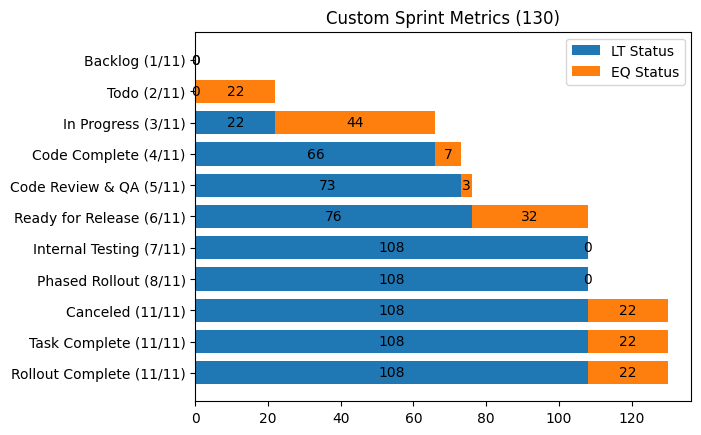

In [45]:
# Get issues from current_cycle
response_json = request_json(issues_query.replace("CYCLE_ID", current_cycle))

# Outfit data to pass to renderer
chart_data = partition_issues(response_json)
total_sprint_points = sum(map(get_points, get_issues(response_json)))

render_chart(chart_data, total_sprint_points)